In [16]:
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from pathlib import Path
import Functions.dataFrameTools as dataFrameTools
import Functions.processGen as processGen
import Functions.convertParams as convertParams
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.spatial.distance import pdist, squareform
from sklearn.mixture import GaussianMixture
import re
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import fcluster, cophenet
import os
import shutil
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from IPython.display import clear_output

from parametricVAE import dVAE, plot_history,freeze_layers_before, unfreeze_all_layers, loadData2, my_loadData2, loadData2, custom_sigmoid_cross_entropy_loss_with_logits


### Fetch datasets

In [ ]:
# Fetch all ratings across all bike groups

rated_bikes_df = pd.read_csv('ratings/combined_clean_ratings.csv')

print(rated_bikes_df.head())

print(rated_bikes_df.shape)

                                    uid   bid  rating
0  01a94a02-93e3-45bf-aef8-54e7a19987d7   997       1
1  01a94a02-93e3-45bf-aef8-54e7a19987d7   752       0
2  01a94a02-93e3-45bf-aef8-54e7a19987d7  4031       1
3  01a94a02-93e3-45bf-aef8-54e7a19987d7  1336       0
4  01a94a02-93e3-45bf-aef8-54e7a19987d7  3827       0
(10350, 3)


C:\Users\fabie\AppData\Local\Temp\ipykernel_5144\862889757.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rated_bikes_df['rating'] = rated_bikes_df['rating'].replace({'yes': 1, 'no': 0})


In [3]:
dfn = dataFrameTools.normalizeDF(0).astype('float32')

visual_df =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
constant_columns = [col for col in visual_df.columns if visual_df[col].nunique() == 1]
visual_df = visual_df.drop(columns=constant_columns)

# rated_bikes_df = pd.read_csv("processed_ratings.csv")

all_my_bikes_df = visual_df.loc[rated_bikes_df['bid'].unique()]

# average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
# usable_bikes = visual_df.loc[average_ratings[average_ratings > 0.7].index]
# unusable_bikes = visual_df.loc[average_ratings[average_ratings < 0.3].index]
# meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
# meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

# usable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == True].index.tolist()
# unusable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == False].index.tolist()



Loaded Imputed Dataframe in  1.6739978790283203 seconds


In [4]:
# Fetch meaningfull bikes 

threshold_usable = 0.7
threshold_unusable = 1- threshold_usable

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings >= threshold_usable].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings <= threshold_unusable].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

usable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == True].index.tolist()
unusable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == False].index.tolist()

In [13]:
input_folder = 'usefull_bike_sets'

usable_bikes_test_df = pd.read_csv(os.path.join(input_folder, 'usable_bikes_test.csv'),index_col=0)
usable_bikes_val_df = pd.read_csv(os.path.join(input_folder, 'usable_bikes_val.csv'),index_col=0)
usable_bikes_train_df = pd.read_csv(os.path.join(input_folder, 'usable_bikes_train.csv'),index_col=0)

unusable_bikes_test_df = pd.read_csv(os.path.join(input_folder, 'unusable_bikes_test.csv'),index_col=0)
unusable_bikes_val_df = pd.read_csv(os.path.join(input_folder, 'unusable_bikes_val.csv'),index_col=0)
unusable_bikes_train_df = pd.read_csv(os.path.join(input_folder, 'unusable_bikes_train.csv'),index_col=0)

usable_bikes_test_dfn = dfn.loc[usable_bikes_test_df.index]
usable_bikes_val_dfn = dfn.loc[usable_bikes_val_df.index]
usable_bikes_train_dfn = dfn.loc[usable_bikes_train_df.index]

unusable_bikes_test_dfn = dfn.loc[unusable_bikes_test_df.index]
unusable_bikes_val_dfn = dfn.loc[unusable_bikes_val_df.index]
unusable_bikes_train_dfn = dfn.loc[unusable_bikes_train_df.index]


### Fetch VAEs

In [ ]:
ddims = 2395

dataVAE_model =dVAE(ddims, 128, 0.1, 1e-3)
dataVAE_mean = dataVAE_model.build_vae_keras_model_mean()
dataVAE_mean.load_weights('model weights/dataVAE.h5')
encoder_mean =  dataVAE_mean.get_layer('encoder')
decoder_mean =  dataVAE_mean.get_layer('decoder')

usable_bikes = dfn.loc[usable_ids] 
unusable_bikes = dfn.loc[unusable_ids] 
encoder = encoder_mean
decoder = decoder_mean

latent_usable = encoder.predict(usable_bikes)
latent_unusable = encoder.predict(unusable_bikes)

# latent_usable_test = encoder.predict(usable_bikes_test_dfn)
# latent_usable_val = encoder.predict(usable_bikes_val_dfn)
# latent_usable_train = encoder.predict(usable_bikes_train_dfn)
# latent_unusable_test = encoder.predict(unusable_bikes_test_dfn)
# latent_unusable_val = encoder.predict(unusable_bikes_val_dfn)
# latent_unusable_train = encoder.predict(unusable_bikes_train_dfn)
clear_output(wait=False)

### Run to visualise bikes in usable,unusable, or other class 

In [75]:
import shutil
import os

# Define source and destination directories
source_dir = '../../BIKED/Standardized Images/'
destination_usable_dir = 'images/usable'
destination_unusable_dir = 'images/unusable'
destination_rest_dir = 'images/rest'

# Ensure destination directories exist
os.makedirs(destination_usable_dir, exist_ok=True)
os.makedirs(destination_unusable_dir, exist_ok=True)
os.makedirs(destination_rest_dir, exist_ok=True)

usable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == True].index.tolist()
unusable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == False].index.tolist()

all_ids = all_my_bikes_df.index.tolist()
usable_set = set(usable_ids)
unusable_set = set(unusable_ids)
all_ids_set = set(all_ids)
rest_ids = all_ids_set - (usable_set.union(unusable_set))
rest_ids_list = list(rest_ids)


# Copy usable images
for img_id in usable_ids:
    src_file = os.path.join(source_dir, f'{img_id}.png')  # Change the extension if needed
    dst_file = os.path.join(destination_usable_dir, f'{img_id}.png')
    if os.path.exists(src_file):
        shutil.copy(src_file, dst_file)
    else:
        print(f"Usable image {src_file} not found.")

# Copy unusable images
for img_id in unusable_ids:
    src_file = os.path.join(source_dir, f'{img_id}.png')  # Change the extension if needed
    dst_file = os.path.join(destination_unusable_dir, f'{img_id}.png')
    if os.path.exists(src_file):
        shutil.copy(src_file, dst_file)
    else:
        print(f"Unusable image {src_file} not found.")

for img_id in rest_ids_list:
    src_file = os.path.join(source_dir, f'{img_id}.png')  # Change the extension if needed
    dst_file = os.path.join(destination_rest_dir, f'{img_id}.png')
    if os.path.exists(src_file):
        shutil.copy(src_file, dst_file)
    else:
        print(f"Unusable image {src_file} not found.")



### Regenerate Original Chosen Bikes

In [440]:
all_latent = np.concatenate((latent_usable, latent_unusable))
res=(tf.math.sigmoid(decoder.predict(all_latent))).numpy()
indices=[f'usable{i}' if i < len(usable_ids) else f'unusable{i-len(usable_ids)}' for i in range(len(usable_ids) + len(unusable_ids))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/all.csv")  # Saving to CSV
processGen.processGen(f"all", denorm=True)

2/2 [==============================] - 0s 3ms/step
Loaded Imputed Dataframe in  0.7064476013183594 seconds
Model unusable18 Seatpost too short
Model unusable23 HTLX + HTUX>HTL
0.9622641509433962 fraction valid


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

One-hot encoding 106 features
Onehot Completed in 0.24818873405456543 seconds
Loaded Imputed Dataframe in  0.7201340198516846 seconds


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

SSSIDECX3   SSSIDECX2   SSSIDECX1   SSSIDECY2   SSSIDECY1  \
usable0      61.930699  132.268585  328.265538  -10.905392    3.997269   
usable1      67.382023  133.885875  301.777011   -7.110732    9.300448   
usable2      63.533315  134.275115  325.827884  -14.083431    8.762222   
usable3     139.716796  136.598422  295.155214   -9.549524   15.163765   
usable4      83.738102  131.772059  279.788402   -8.351743   22.161824   
usable5      73.968680  144.860329  180.069217  -10.125342  -14.955564   
usable6      65.869164  125.435738  264.056403  -16.786865   12.069104   
usable7      80.906419  151.110427  353.398118    2.962863    9.935210   
usable8     128.583881  130.711469  310.772826  -12.971188   11.757602   
usable9      64.638245  152.216683  341.135514    2.258258   16.308742   
usable10     82.084307  127.804373  311.118209   -6.927933   13.187998   
usable11     75.418773  138.803869  327.424598    1.274681   10.781312   
usable12     82.298765  137.520332  330.696627   -9.966569    6.547016   
usable13    116.717964  121.141160  292.959651  -13.189678   -2.353190   
usable14     75.647764  134.766622  304.479120   -6.488017    2.937238   
usable15     65.031739  120.190924  283.691738  -11.683542   16.249421   
usable16     52.432897  123.248772  291.172152   -9.465592    4.554080   
usable17     46.221843  136.648711  307.319829   -9.844296   17.206544   
usable18     68.076291  130.921731  307.004576  -11.154399   10.313918   
usable19     62.735804  106.477109  269.593595   10.580518  -79.218347   
unusable0    71.109132  153.732126  360.557901   -5.968520   21.974560   
unusable1    58.377144  132.648680  314.833918   -5.466334   12.448894   
unusable2    67.245589  126.050264  287.453144   -9.153730   -5.761526   
unusable3    79.842862  129.567715  310.715323   -7.026023    9.816850   
unusable4    59.455103  134.493833  322.077497   -3.027763    4.698550   
unusable5    58.399763  168.340762  389.882298   -6.098254   16.268288   
unusable6    62.522355  154.331807  366.993521   -4.892451    5.641426   
unusable7    51.374712  118.505298  272.775942  -19.669436   18.268326   
unusable8    93.263313  217.152596  461.734907  103.245246   -1.003701   
unusable9    83.825334  128.961480  322.043282  -11.339066    8.250714   
unusable10  139.490120  293.771964  377.515709   -1.207359  267.208472   
unusable11  110.026610  171.801828  325.619498   -8.876521  -19.398904   
unusable12   83.076562  140.831296  310.889078   -7.413408    5.514248   
unusable13   73.750657  124.095707  240.711939  -11.319967   -8.947021   
unusable14   88.737376  159.569275  290.095855    0.109368  -23.557573   
unusable15   75.881686  135.780795  305.460864   -9.482897   -2.450482   
unusable16   81.823879  140.780497  309.233922  -10.596801   11.382150   
unusable17  132.138829  136.410683  317.360623  -12.431350   14.150550   
unusable19   72.728727   78.612029  302.186477  -13.312972   23.740333   
unusable20   55.250404  123.783770  294.877736  -10.514406    8.182522   
unusable21   57.768708  128.490104  279.534767   19.662119   22.887780   
unusable22   59.743729  119.683627  263.810982   -6.741739   13.140064   
unusable24   67.845221  135.278121  310.331703  -12.912938   10.395925   
unusable25   63.639333  135.891161  324.144585   -7.922458    8.184986   
unusable26   63.178460  126.621918  323.367204  -12.636142  -46.484054   
unusable27   69.244417  136.364654  300.898927   -5.443159   14.216920   
unusable28  111.666651  123.532650  294.008762  -11.849031    3.004488   
unusable29   60.845457  134.311413  327.083561   -5.870375   21.120696   
unusable30   73.866262  143.080030  331.739434   -5.094612    9.058844   
unusable31   73.135135   77.411801  176.485604   14.780714   27.411323   
unusable32   75.532755  130.346538  311.351038   -8.203513   17.202602   

            STEMBENDS  FRONTROTORBOLTS  Shoe up angle  \
usable0             0                6             36   
usable1             0                6            

# Creating GMM (Ignore)

## Determining the number of clusters

### Heirachical Clustering in Latent Space

In [9]:

def numerical_sort(value):
    # Extracts numerical parts from the file name
    numbers = re.findall(r'\d+', value)
    return list(map(int, numbers)) if numbers else [0]


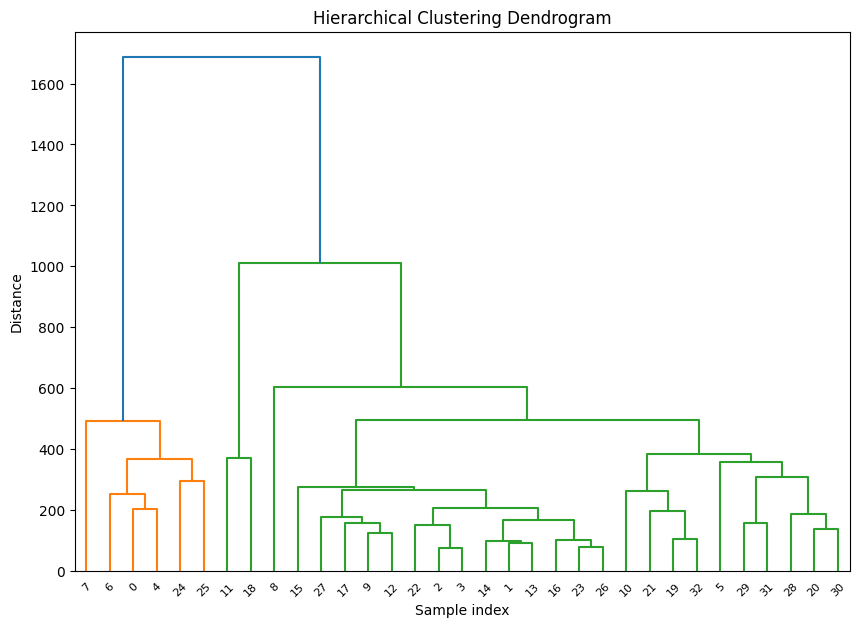

In [10]:

unusable_bikes_visual = visual_df.loc[unusable_ids]

Z = linkage(unusable_bikes_visual, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


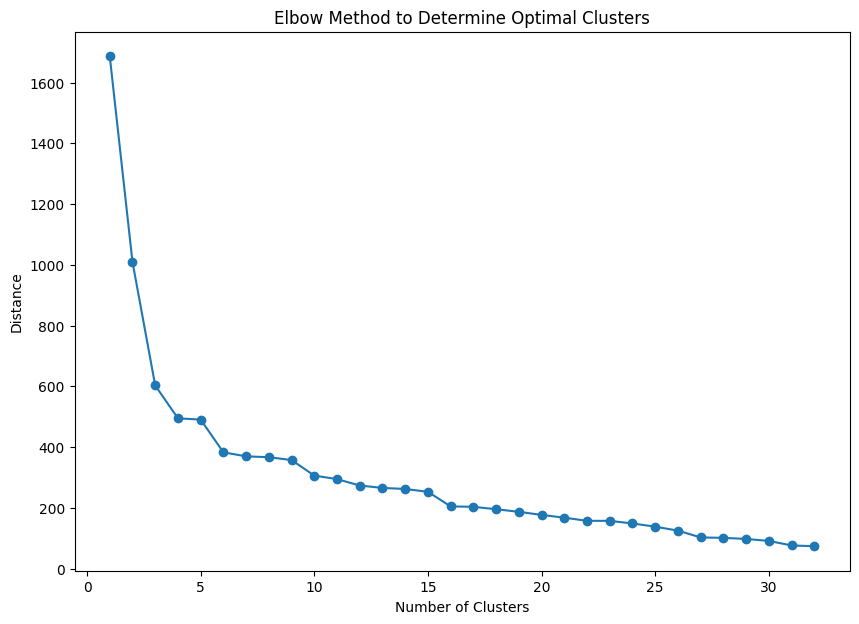

Optimal number of clusters: 6


In [13]:
coph_dist = cophenet(Z)[0]
coph_corr = cophenet(Z, pdist(unusable_bikes_visual))[1]

# Plot the inconsistency matrix to find the best number of clusters
max_d = 32  # Adjust this value according to the dendrogram visualization
last = Z[-max_d:, 2]
last_rev = last[::-1]
indexes = np.arange(1, len(last) + 1)

plt.figure(figsize=(10, 7))
plt.plot(indexes, last_rev, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distance')
plt.show()

second_derivative = np.diff(last_rev, 2)# Identify the optimal number of clusters (elbow point)
second_derivative_modified = second_derivative[1:]
top_indices = np.argsort(second_derivative_modified)[-3:]  # This gives the indices of the two highest values

# Select the one with the highest index (i.e., the largest position in the array)
highest_index = max(top_indices)
optimal_num_clusters = highest_index + 3
# optimal_num_clusters = np.abs(np.diff(last_rev, 2)).argmax() + 3 # accounts for zero-indexing
# optimal_num_clusters = np.diff(last, 2).argmax() + 2  # +2 accounts for zero-indexing
print(f'Optimal number of clusters: {optimal_num_clusters}')


#### Visualise cluster groups using either k-means or GMMs directly

##### K-means


In [22]:
usability_type = 'unusable'  # or 'unusable'
num_clusters = [ 11, 12]  # Can fit multiple K-means instances

src = f'images/{usability_type}/'  # Source directory with images

image_filenames = os.listdir(src)
image_filenames.sort(key=numerical_sort)

for num in num_clusters:
    dst = f'images/clustered/{usability_type}/{num}clust/'  
    if not os.path.exists(dst):
        os.makedirs(dst)
    kmeans = KMeans(n_clusters=num, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(latent_usable)
    cluster_labels = kmeans.labels_

    for cluster in range(num):
        cluster_dir = os.path.join(dst, f'cluster_{cluster}')
        if not os.path.exists(cluster_dir):
            os.makedirs(cluster_dir)

    for idx, label in enumerate(cluster_labels):
        src_file = os.path.join(src, image_filenames[idx])
        dst_file = os.path.join(dst, f'cluster_{label}', image_filenames[idx])
        shutil.copy2(src_file, dst_file)

print("Images have been grouped and copied to the destination directory.")


Images have been grouped and copied to the destination directory.


##### GMM


In [25]:
usability_type = 'unusable' 

gmms = []
num_clusters = [8,10,12,13,15]

src = f'images/{usability_type}/'  # Source directory with images

image_filenames = os.listdir(src)
image_filenames.sort(key=numerical_sort)

for num in num_clusters:
    dst = f'images/clustered/{usability_type}/{num}clust/'  # Destination directory for grouped images
    if not os.path.exists(dst):
        os.makedirs(dst)
    gmm = GaussianMixture(n_components=num,  covariance_type='full', max_iter=300, n_init=10, random_state=42)
    gmm.fit(latent_unusable)
    gmms.append(gmm)
    cluster_labels = gmm.predict(latent_unusable)

    for cluster in range(num):
        cluster_dir = os.path.join(dst, f'cluster_{cluster}')
        if not os.path.exists(cluster_dir):
            os.makedirs(cluster_dir)

    for idx, label in enumerate(cluster_labels):
        src_file = os.path.join(src, image_filenames[idx])
        dst_file = os.path.join(dst, f'cluster_{label}', image_filenames[idx])
        shutil.copy2(src_file, dst_file)

print("Images have been grouped and copied to the destination directory.")


Images have been grouped and copied to the destination directory.


In [ ]:
# gmm_unusable = gmms[2]


In [26]:
# main_folder = 'images/clustered/unusable/manual/'
# all_clusters = []
# for subfolder_name in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder_name)
#     cluster = []
#     if os.path.isdir(subfolder_path):  # Check if it's a directory
#         for image_name in os.listdir(subfolder_path):
#             bike_id = os.path.splitext(image_name)[0]  # Remove file extension to get the ID
#             row_index = unusable_bikes.index.get_loc(int(bike_id))
#             cluster.append( latent_unusable[row_index])
#     all_clusters.append(cluster)
# all_clusters

## Generating new bikes from from GMMs

In [134]:
n_components_usable = 11 
gmm_usable = GaussianMixture(n_components=n_components_usable, covariance_type='full', random_state=123)
gmm_usable.fit(latent_usable)

# gmm_unusable = gmms[2]
n_components_unusable = 15 
gmm_unusable = GaussianMixture(n_components=n_components_unusable, covariance_type='full', random_state=123)
gmm_unusable.fit(latent_unusable)

In [135]:
usable = False
if usable:
    gmm = gmm_usable
    text = 'usable'
else:
    gmm = gmm_unusable
    text = 'unusable'

n_samples = 10
sampled_latent, _ = gmm.sample(n_samples)

res=(tf.math.sigmoid(decoder.predict(sampled_latent))).numpy()
indices=[f'{text}{i}' for i in range(len(sampled_latent))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/{text}.csv")  # Saving to CSV
processGen.processGen(f"{text}", denorm=True)



1/1 [==============================] - 0s 22ms/step
Loaded Imputed Dataframe in  1.8185036182403564 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

One-hot encoding 106 features
Onehot Completed in 0.8064942359924316 seconds
Loaded Imputed Dataframe in  1.5377252101898193 seconds


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

SSSIDECX3   SSSIDECX2   SSSIDECX1  SSSIDECY2  SSSIDECY1  \
unusable0   58.567906  189.046849  413.229613   0.034429  20.016340   
unusable1   81.663977  157.167792  370.063622  -0.953430  18.095432   
unusable2   63.781990  121.168939  272.706588  27.741991  18.071320   
unusable3   84.407816  153.497083  382.605784 -14.403407   5.733104   
unusable4   80.062562  149.230532  258.976084 -10.019795 -50.813417   
unusable5  103.994552  213.764241  392.477941  79.323967  16.718258   
unusable6   50.871951  124.881915  284.588732 -14.933134  14.409904   
unusable7  117.234329  134.425784  314.097610  -6.103930  20.490792   
unusable8   49.946295  136.916966  315.843266 -10.611102  20.012230   
unusable9   49.919964  136.903548  315.765682 -10.616659  19.980392   

           STEMBENDS  FRONTROTORBOLTS  Shoe up angle  \
unusable0          0                6             36   
unusable1          0                6             37   
unusable2          0                6             39   
unusable3          0                6             41   
unusable4          0                6             38   
unusable5          0                6             34   
unusable6          0                6             37   
unusable7          0                6             38   
unusable8          0                6             37   
unusable9          0                6             37   

           Down tube front diameter  LRTHICK  ...  \
unusable0                 43.797562       10  ...   
unusable1                 39.844355       10  ...   
unusable2                 39.321851       10  ...   
unusable3                 36.687334       10  ...   
unusable4                 45.685427       10  ...   
unusable5                 41.171598       10  ...   
unusable6                 42.014066       10  ...   
unusable7                 38.900784       10  ...   
unusable8                 34.554244       10  ...   
unusable9                 34.553380       10  ...   

           Saddle type OHCLASS: Specialized Romin  \
unusable0                                       0   
unusable1                                       0   
unusable2                                       0   
unusable3                                       0   
unusable4                                       0   
unusable5                                       0   
unusable6                                       0   
unusable7                                       0   
unusable8                                       0   
unusable9                                       0   

           Saddle type OHCLASS: Specialized Toupe  \
unusable0                                       0   
unusable1                                       0   
unusable2                                       0   
unusable3                                       0   
unusable4                                       0   
unusable5                                       0   
unusable6                                       0   
unusable7                                       0   
unusable8                                       0   
unusable9                                       0   

           Saddle type OHCLASS: WILIER Selle Italia  \
unusable0                                         0   
unusable1                                         0   
unusable2                                         0   
unusable3                                         0   
unusable4                                         0   
unusable5                                         0   
unusable6                                         0   
unusable7                                         0   
unusable8                                         0   
unusable9                                         0   

           Saddle type OHCLASS: WTB Rocket Vee  \
unusable0                                    0   
unusable1                                    0   
unusable2                                    0   
unusable3                                    0   
unusa

In [15]:
denorm_df = dataFrameTools.deNormalizeDF(meandf, intermediates=0)
deOH = dataFrameTools.deOH(denorm_df)
conv = convertParams.convert(deOH, "clip_s")
columns_to_exclude = ['usable']
filtered_columns = [col for col in meaningfull_bikes_df.columns if col not in columns_to_exclude]
filtered_deOH = conv[filtered_columns]

Loaded Imputed Dataframe in  1.6041827201843262 seconds


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

### Custom GMM Model fitted on manually clustered bikes

In [377]:
class customGMM():
    def __init__(self, GMMS):

        self.GMMS = GMMS

    def sample(self, n_samples, cluster_ind = None):
        if cluster_ind == None:
            all_points = []
            for i in range(n_samples):
                sampled, _ = self.GMMS[random.randint(0,len(self.GMMS)-1)].sample(1)
                squeesed = np.squeeze(sampled)
                all_points.append(sampled[0]) 
            return np.vstack(all_points)
        else:
            sampled, _ = self.GMMS[cluster_ind].sample(n_samples)
            return sampled

def cluster_from_folder(df:pd.DataFrame,latent_array:np, folder_path):
    gmms = []
    
    for cluster_folder in os.listdir(folder_path):
        cluster_dir = os.path.join(folder_path, cluster_folder)
       
        if len(os.listdir(cluster_dir)) < 2:
            continue
        bike_ind = []

        for imgs in os.listdir(cluster_dir):
            bike_id = int(os.path.splitext(imgs)[0])
            ind = df.index.get_loc(bike_id)
            bike_ind.append(ind)

        cluster = latent_array[bike_ind]
        gmm = GaussianMixture(n_components=1,  covariance_type='full')
        gmm.fit(cluster)

        gmms.append(gmm)
    return gmms
            


In [383]:
clust_path = 'images/clustered/unusable/manual/'
GMMS = cluster_from_folder(unusable_bikes,latent_unusable, clust_path)
myGMM = customGMM(GMMS)


#### Generate new bikes based on a spacific cluster

In [409]:
cluster_ind = 0
n_samples = 10
sampled = myGMM.sample(n_samples, cluster_ind)

text = 'myGMM'+ str(cluster_ind)
res=(tf.math.sigmoid(decoder.predict(sampled))).numpy()
indices=[f'{text}{i}' for i in range(len(sampled))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/{text}.csv")  # Saving to CSV
processGen.processGen(f"{text}", denorm=True)

1/1 [==============================] - 0s 26ms/step
Loaded Imputed Dataframe in  1.4621860980987549 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

One-hot encoding 106 features
Onehot Completed in 0.38451218605041504 seconds
Loaded Imputed Dataframe in  1.42620849609375 seconds


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

SSSIDECX3   SSSIDECX2   SSSIDECX1  SSSIDECY2  SSSIDECY1  STEMBENDS  \
myGMM00  79.283783  144.260795  353.473097  -6.626716   7.109750          0   
myGMM01  70.909364  153.571981  370.038177   8.474049  31.584732          0   
myGMM02  66.177143  136.603619  298.475190 -21.833147   5.369224          0   
myGMM03  81.138607  131.902833  364.568658  -4.922071  20.598064          0   
myGMM04  75.457467  135.514810  278.882685 -16.379985  13.665468          0   
myGMM05  81.046399  122.403979  292.029337 -15.601238   9.508982          1   
myGMM06  92.776393  138.380787  344.211810  10.782440  -0.862144          0   
myGMM07  77.578768  119.257478  308.965152  -1.440542  21.539893          0   
myGMM08  58.450710  128.972384  297.498948  -4.610361   7.792938          0   
myGMM09  80.228194  134.249518  349.022266   2.073922  18.528568          0   

         FRONTROTORBOLTS  Shoe up angle  Down tube front diameter  LRTHICK  \
myGMM00                6             35                 40.003847       10   
myGMM01                6             35                 40.419808       10   
myGMM02                6             35                 39.074165       10   
myGMM03                6             36                 41.653240       10   
myGMM04                6             36                 28.156016       10   
myGMM05                6             39                 65.836438       10   
myGMM06                6             36                 46.012993       10   
myGMM07                6             34                 34.697968       10   
myGMM08                6             36                 26.573131       10   
myGMM09                6             36                 43.537914       10   

         ...  Saddle type OHCLASS: fi'zi:k Aliante  \
myGMM00  ...                                     0   
myGMM01  ...                                     0   
myGMM02  ...                                     0   
myGMM03  ...                                     0   
myGMM04  ...                                     0   
myGMM05  ...                                     0   
myGMM06  ...                                     0   
myGMM07  ...                                     0   
myGMM08  ...                                     0   
myGMM09  ...                                     0   

         Saddle type OHCLASS: fi'zi:k Antares  \
myGMM00                                     0   
myGMM01                                     0   
myGMM02                                     0   
myGMM03                                     0   
myGMM04                                     0   
myGMM05                                     0   
myGMM06                                     0   
myGMM07                                     0   
myGMM08                                     0   
myGMM09                                     0   

         Saddle type OHCLASS: fi'zi:k Arione  \
myGMM00                                    0   
myGMM01                                    0   
myGMM02                                    0   
myGMM03                                    0   
myGMM04                                    0   
myGMM05                                    0   
myGMM06                                    0   
myGMM07                                    0   
myGMM08                                    0   
myGMM09                                    0   

         Saddle type OHCLASS: fi'zi:k Arione TRI  \
myGMM00                                        0   
myGMM01                                        0   
myGMM02                                        0   
myGMM03                                        0   
myGMM04                                        0   
myGMM05                                        0   
myGMM06                                        0   
myGMM07                                        0   
myGMM08                                        0   
myGMM09                                        0   

         Saddle type OHCLASS: fi'zi:k Gobi 

##### Random bike generations

In [425]:
n_samples = 10
sampled = myGMM.sample(n_samples)

text = 'random'
res=(tf.math.sigmoid(decoder.predict(sampled))).numpy()
indices=[f'{text}{i}' for i in range(len(sampled))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/{text}.csv")  # Saving to CSV
processGen.processGen(f"{text}", denorm=True)

1/1 [==============================] - 0s 23ms/step
Loaded Imputed Dataframe in  1.5992262363433838 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

One-hot encoding 106 features
Onehot Completed in 0.5010921955108643 seconds
Loaded Imputed Dataframe in  1.1318604946136475 seconds


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

SSSIDECX3   SSSIDECX2   SSSIDECX1  SSSIDECY2   SSSIDECY1  STEMBENDS  \
random0   61.710630  158.332494  387.743837  14.154566   18.664968          0   
random1  143.436540  212.156064  519.805211  11.782894  144.843997          1   
random2   83.055824  139.984615  318.263150   0.215154   13.280512          0   
random3   59.161143  108.592047  264.841968  -1.352020   11.947374          0   
random4  138.119256  234.598143  413.223263   6.080140  122.205205          0   
random5   62.758266  113.895709  266.841875   3.403368    7.814542          0   
random6  143.362506  213.240199  458.050560   6.850820  162.574246          1   
random7  123.047589  185.238945  384.834591   1.644360    6.149115          0   
random8   60.475982  132.495677  312.916542 -17.351570   -6.904347          0   
random9   83.772671  139.712470  293.305327  -7.719023   12.126709          0   

         FRONTROTORBOLTS  Shoe up angle  Down tube front diameter  LRTHICK  \
random0                6             36                 44.047767       10   
random1                6             34                 43.114673       10   
random2                6             34                 42.598816       10   
random3                6             37                 42.612734       10   
random4                6             35                 40.709243       10   
random5                6             36                 42.674432       10   
random6                6             35                 45.149676       10   
random7                6             35                 40.658180       10   
random8                6             40                 39.390256       10   
random9                6             35                 41.858154       10   

         ...  Saddle type OHCLASS: Specialized Toupe  \
random0  ...                                       0   
random1  ...                                       0   
random2  ...                                       0   
random3  ...                                       0   
random4  ...                                       0   
random5  ...                                       0   
random6  ...                                       0   
random7  ...                                       0   
random8  ...                                       0   
random9  ...                                       0   

         Saddle type OHCLASS: WILIER Selle Italia  \
random0                                         0   
random1                                         0   
random2                                         0   
random3                                         0   
random4                                         0   
random5                                         0   
random6                                         0   
random7                                         0   
random8                                         0   
random9                                         0   

         Saddle type OHCLASS: WTB Rocket Vee  \
random0                                    0   
random1                                    0   
random2                                    0   
random3                                    0   
random4                                    0   
random5                                    0   
random6                                    0   
random7                                    0   
random8                                    0   
random9                                    0   

         Saddle type OHCLASS: fi'zi:k Antares  \
random0                                     0   
random1                                     0   
random2                                     0   
random3                                     0   
random4                                     0   
random5                                     0   
random6                                     0   
random7                                     0   
random8                                     0   
random9                                

# Kernel Density Model

## Finding best KDE parameters using cross validation

In [20]:
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.01, 1.0, 100)}, cv=5)
grid.fit(latent_unusable)
best_bandwidth = grid.best_params_['bandwidth']

kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
kde.fit(latent_unusable)


# grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.01, 1.0, 100)}, cv=5)
# grid.fit(latent_usable_train)
# best_bandwidth = grid.best_params_['bandwidth']
# print(best_bandwidth)
# kde_usable = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
# kde_usable.fit(latent_usable_train)

# grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.01, 1.0, 100)}, cv=5)
# grid.fit(latent_unusable_train)
# best_bandwidth = grid.best_params_['bandwidth']
# print(best_bandwidth)
# kde_unusable = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
# kde_unusable.fit(latent_unusable_train)

KernelDensity(bandwidth=0.23)

## Visualising effect of bandwidth on generated designs

### Random sampling (not very informative)

In [482]:
bandwidths  = [0.3,0.5,1,2]
num_samples_per_bw = 10

for bandwidth in bandwidths:
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(latent_unusable)

    samples = kde.sample(n_samples=num_samples_per_bw) 

    text = f'{bandwidth}kde'
    res=(tf.math.sigmoid(decoder.predict(samples))).numpy()
    indices=[f'{text}{i}' for i in range(len(sampled))]
    meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
    meandf.to_csv(f"../data/{text}.csv")  # Saving to CSV
    processGen.processGen(f"{text}", denorm=True)


1/1 [==============================] - 0s 127ms/step
Loaded Imputed Dataframe in  1.7054851055145264 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

One-hot encoding 106 features
Onehot Completed in 3.576122760772705 seconds
Loaded Imputed Dataframe in  1.453944444656372 seconds


c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

SSSIDECX3   SSSIDECX2   SSSIDECX1  SSSIDECY2  SSSIDECY1  STEMBENDS  \
0.5kde0  73.641880  124.034731  240.304353 -12.887785  -7.441402          0   
0.5kde1  76.665515  129.921110  298.778668  -6.354557  20.853818          0   
0.5kde2  58.342651  155.994654  322.167888  -9.037576  27.806760          0   
0.5kde3  85.691646  138.346766  326.142843  -8.790901  13.578190          0   
0.5kde4  58.180426  133.845911  276.968129  10.744462  12.107032          0   
0.5kde5  77.304972  115.159337  315.549467 -11.854446   5.243824          0   
0.5kde6  64.367335  134.973785  303.474041  -8.375355  12.965974          0   
0.5kde7  92.551433  160.517471  304.213031   0.943748  -6.583130          0   
0.5kde8  69.048619  146.686606  356.342087  -6.051444   9.294200          0   
0.5kde9  71.385583  118.959614  296.325709  -1.623811  13.302899          1   

         FRONTROTORBOLTS  Shoe up angle  Down tube front diameter  LRTHICK  \
0.5kde0                6             36                 40.717732       10   
0.5kde1                6             35                 37.599832       10   
0.5kde2                6             36                 35.710727       10   
0.5kde3                6             35                 41.429433       10   
0.5kde4                6             39                 33.756680       10   
0.5kde5                6             36                 39.813667       10   
0.5kde6                6             35                 36.549610       10   
0.5kde7                6             35                 40.026129       10   
0.5kde8                6             36                 48.007700       10   
0.5kde9                6             37                 37.478757       10   

         ...  Saddle type OHCLASS: WTB Rocket Vee  \
0.5kde0  ...                                    0   
0.5kde1  ...                                    0   
0.5kde2  ...                                    0   
0.5kde3  ...                                    0   
0.5kde4  ...                                    0   
0.5kde5  ...                                    0   
0.5kde6  ...                                    0   
0.5kde7  ...                                    0   
0.5kde8  ...                                    0   
0.5kde9  ...                                    0   

         Saddle type OHCLASS: fi'zi:k Antares  \
0.5kde0                                     0   
0.5kde1                                     0   
0.5kde2                                     0   
0.5kde3                                     0   
0.5kde4                                     0   
0.5kde5                                     0   
0.5kde6                                     0   
0.5kde7                                     0   
0.5kde8                                     0   
0.5kde9                                     0   

         Saddle type OHCLASS: fi'zi:k Arione  \
0.5kde0                                    0   
0.5kde1                                    0   
0.5kde2                                    0   
0.5kde3                                    0   
0.5kde4                                    0   
0.5kde5                                    0   
0.5kde6                                    0   
0.5kde7                                    0   
0.5kde8                                    0   
0.5kde9                                    0   

         Saddle type OHCLASS: fi'zi:k Arione TRI  \
0.5kde0                                        0   
0.5kde1                                        0   
0.5kde2                                        0   
0.5kde3                                        0   
0.5kde4                                        0   
0.5kde5                                        0   
0.5kde6                                        0   
0.5kde7                                        0   
0.5kde8                                        0   
0.5kde9                                        0   

         Saddle type OHCLASS: fi'zi:k Gobi  \
0.5kde0 

### Specific cluster

In [ ]:
def get_latent_from_folder(df:pd.DataFrame,latent_array:np, folder_path):
    bike_ind = []
    for imgs in os.listdir(folder_path):
        bike_id = int(os.path.splitext(imgs)[0])
        ind = df.index.get_loc(bike_id)
        bike_ind.append(ind)

    return latent_array[bike_ind]

bandwidths  = [0.3,0.5,1,2]
folder = 3
bandwidth = 0.3
num_samples_per_bw = 10
path = f'images/clustered/unusable/manual/{folder}'

cluster_latent = get_latent_from_folder(unusable_bikes,latent_unusable,path)

kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
kde.fit(cluster_latent)


samples = kde.sample(n_samples=num_samples_per_bw) 

text = f'{bandwidth}kde_folder{folder}'
res=(tf.math.sigmoid(decoder.predict(samples))).numpy()
indices=[f'{text}_{i}' for i in range(len(sampled))]
meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
meandf.to_csv(f"../data/{text}.csv")  # Saving to CSV
processGen.processGen(f"{text}", denorm=True)


# Reasoning for improvement over GMMs

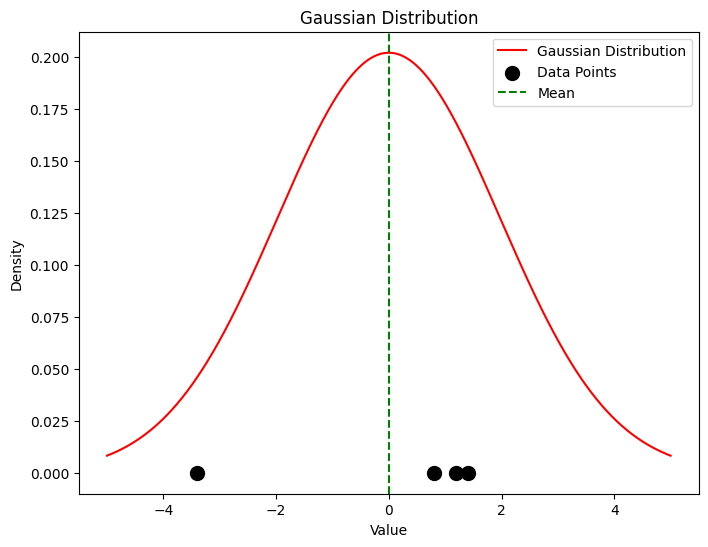

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

data = [-3.4,1.2,0.8,1.4]

# Plot Gaussian distribution
x = np.linspace(-5, 5, 1000)
gaussian_pdf = norm.pdf(x, loc=np.mean(data), scale=np.std(data))

plt.figure(figsize=(8, 6))

plt.plot(x, gaussian_pdf, 'r-', label='Gaussian Distribution')
plt.scatter(data, np.zeros_like(data), color='black', marker='o', s=100, label='Data Points')
plt.axvline(np.mean(data), color='green', linestyle='--', label='Mean')
plt.title('Gaussian Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(loc='upper right')

# # Plot KDE
# plt.subplot(1, 2, 2)
# sns.kdeplot(data, bw_adjust=0.5, fill=True)
# plt.title('Kernel Density Estimate (KDE)')
# plt.xlabel('Value')
# plt.ylabel('Density')

# plt.tight_layout()
# plt.show()


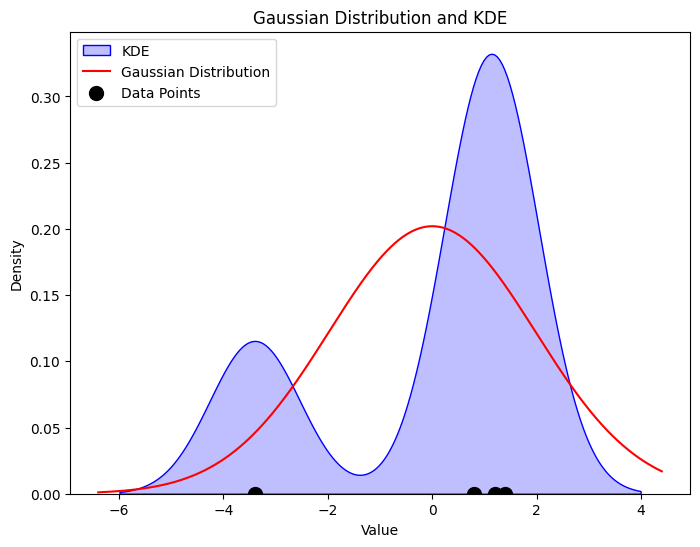

In [473]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Sample data
data = [-3.4,1.2,0.8,1.4]


# Create a range of values for plotting
x = np.linspace(min(data) - 3, max(data) + 3, 1000)

# Calculate Gaussian distribution
mean = np.mean(data)
std_dev = np.std(data)
gaussian_pdf = norm.pdf(x, loc=mean, scale=std_dev)

# Plotting
plt.figure(figsize=(8, 6))

# Plot KDE
sns.kdeplot(data, bw_adjust=0.5, fill=True, label='KDE', color='blue')

# Plot Gaussian distribution
plt.plot(x, gaussian_pdf, 'r-', label='Gaussian Distribution')
plt.scatter(data, np.zeros_like(data), color='black', marker='o', s=100, label='Data Points')

# Add labels and legend
plt.title('Gaussian Distribution and KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.show()


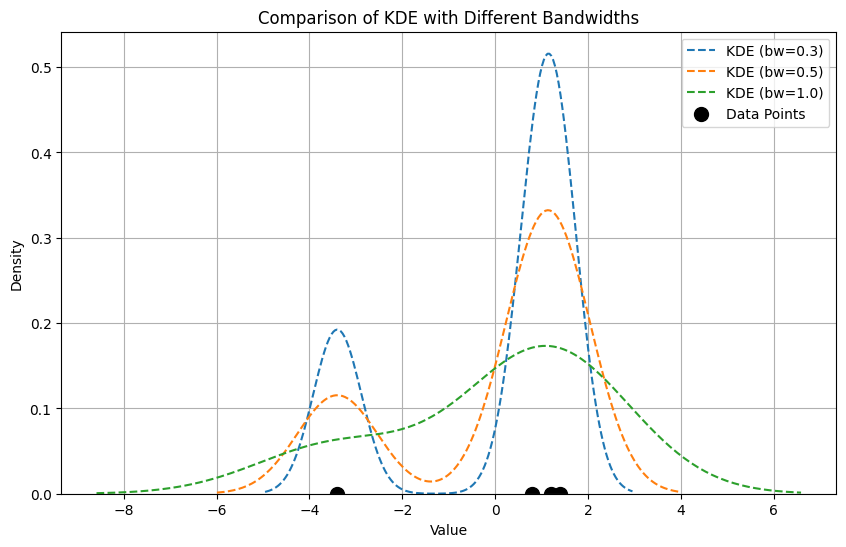

In [479]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Sample data
data = [-3.4, 1.2, 0.8, 1.4]

# Create a range of values for plotting
x = np.linspace(min(data) - 3, max(data) + 3, 1000)

# Calculate Gaussian distribution
mean = np.mean(data)
std_dev = np.std(data)
gaussian_pdf = norm.pdf(x, loc=mean, scale=std_dev)

# Plotting
plt.figure(figsize=(10, 6))


# Define bandwidths to compare
bandwidths = [0.3,0.5, 1.0]

# Plot KDE with different bandwidths
for bw in bandwidths:
    sns.kdeplot(data, bw_adjust=bw, fill=False, label=f'KDE (bw={bw})', linestyle='--')

# Plot data points
plt.scatter(data, np.zeros_like(data), color='black', marker='o', s=100, label='Data Points')

# Add labels and legend
plt.title('Comparison of KDE with Different Bandwidths')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# # Needs to be 61 cols
# def convert_to_visual(df):
#     denorm_df = dataFrameTools.deNormalizeDF(df, intermediates=0)
#     deOH = dataFrameTools.deOH(denorm_df)
#     conv = convertParams.convert(deOH, "clip_s")
#     columns_to_exclude = ['usable']
#     filtered_columns = [col for col in meaningfull_bikes_df.columns if col not in columns_to_exclude]
#     filtered_deOH = conv[filtered_columns]
#     return filtered_deOH

In [29]:
# all_latent = np.concatenate((latent_usable, latent_unusable))
# res=(tf.math.sigmoid(decoder.predict(all_latent))).numpy()
# indices=[f'usable{i}' if i < len(usable_ids) else f'unusable{i-len(usable_ids)}' for i in range(len(usable_ids) + len(unusable_ids))]
# meandf=pd.DataFrame(res, index=indices, columns=dfn.columns)
# meandf.to_csv(f"../data/all.csv")  # Saving to CSV
# processGen.processGen(f"all", denorm=True)

In [30]:
# convert_to_visual(meandf)